# Programação Genética - Trabalho Final
## Leonardo Augusto Ferreira
### leauferreira@cpdee.ufmg.br

## Alunos:
### Gabriel Camatta Zanotelli - 2018020140
### Lucas de Almeida Martins - 2018020328

---
# Relatório

Nesta atividade analisamos a eficiência das bibliotecas de Programação Genética *EC-KitY* e *GPlearn* de forma a fazer uma análise da eficiência de ambas, por meio da utilização de diversos conjuntos de dados disponíveis na biblioteca *pmlb*.

Esta análise será feita utilizando ambas as bibliotecas para resolução de problemas binários e mono objetivo de três conjuntos de dados selecionados, variando dois parâmetros de imensa importância: a probabilidade de mutação e cruzamento. Para cada combinação, serão realizadas diversas iterações, de forma a obter um resultado médio.


### Dependencias

In [ ]:
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_log_error
from gplearn.genetic import SymbolicRegressor
from eckity.algorithms.simple_evolution import SimpleEvolution
from eckity.sklearn_compatible.sk_classifier import SKClassifier
from eckity.breeders.simple_breeder import SimpleBreeder
from eckity.creators.gp_creators.ramped_hh import RampedHalfAndHalfCreator
from eckity.genetic_encodings.gp.tree.functions import f_add, f_mul, f_sub, f_div, f_min, f_max, f_sin, f_cos, f_log
from eckity.genetic_encodings.gp.tree.utils import create_terminal_set
from eckity.genetic_operators.crossovers.subtree_crossover import SubtreeCrossover
from eckity.genetic_operators.mutations.subtree_mutation import SubtreeMutation
from eckity.genetic_operators.selections.tournament_selection import TournamentSelection
from eckity.statistics.best_avg_worst_size_tree_statistics import BestAverageWorstSizeTreeStatistics
from eckity.subpopulation import Subpopulation
from eckity.termination_checkers.threshold_from_target_termination_checker import ThresholdFromTargetTerminationChecker
from eckity.sklearn_compatible.classification_evaluator import ClassificationEvaluator

### Conjuntos de dados

Os dados selecionados para esse estudo foram sobre casos de Diabetes, formações de nuvens (que será referido como *Clounds*) e de Íris.

In [ ]:
x1, y1 = fetch_data('diabetes', return_X_y=True)
x2, y2 = fetch_data('cloud', return_X_y=True)
x3, y3 = fetch_data('iris', return_X_y=True)

### Parâmetros

Para ambas as bibliotecas serão adotados alguns parâmetros padrõesao longo dos testes realizados.
- **EC-KitY**
    - População máxima de 1000 indivíduos
    - Mesmo conjunto de equações para a resolução do problema (adição, subtração, multiplicação, divisão, máximo, mínimo, seno, cosseno, logarítmo)
    - Valores base de probabilidade de mutação como 70% e probabilidade de cruzamento e 100%
    - Serão testados valores da probabilidade de mutação de 30-90%, com um passo de 20%
    - Serão testados valores da probabilidade de cruzamento de 40-100%, com um passo de 20%
    - Máximo de 100 gerações
    - Para cada caso, serão feitas um número de execuções de garantam uma certa segurança dos resultados. Para essa ativiade, serão feitas 10 iterações

- **GPLearn**
    - População máxima de 1000 indivíduos
    - Mesmo conjunto de equações para a resolução do problema (adição, subtração, multiplicação, divisão, máximo, mínimo, seno, cosseno, logarítmo)
    - Como a biblioteca exige que a somatória das probabilidade de cruzamento e mutações (*Subtree*, *hois* e *point*) tenham uma somatória total de 1, o programa será executado 4 vezes, sempre com a probabilidade iguais dos três tipos de mutação. As configurações são:
        - Probabilidade de cruzamento de 90%; probabilidade de mutação de 3,33%
        - Probabilidade de cruzamento de 80%; probabilidade de mutação de 6,67%
        - Probabilidade de cruzamento de 70%; probabilidade de mutação de 10%
        - Probabilidade de cruzamento de 60%; probabilidade de mutação de 13,33%
    - Máximo de 100 gerações
    - Para cada caso, serão feitas um número de execuções de garantam uma certa segurança dos resultados. Para essa ativiade, serão feitas 10 iterações

### Métricas

Como indicado no guia do trabalho, foram usadas quatro métricas para avaliação das bibliotecas:
- **Acurácia:** medida que quantifica a precisão de um modelo ou método em prever corretamente o resultado de um evento.
- **F1-score:** medida que combina a precisão e a revocação de um modelo ou método em um único valor, calculada como a média harmônica entra ambas. Um F1-score alto indica um bom equilíbrio entre precisão e revocação, enquanto um valor baixo sugere que o modelo pode estar com dificuldades em encontrar o compromisso ideal entre essas duas métricas.
- **Recall:** medida que avalia a capacidade de um modelo ou método em identificar corretamente todas as instâncias positivas de um evento. um recall alto indica que uma alta quantidade de casos positivos foram detectados corretamente.
- **Erro médio quadrático (RMSE):** métrica que mede a diferença média ao quadrado entre os valores previstos e os valores reais de um modelo ou método, com um erro menor indicando um melhor desempenho do modelo em relação à precisão das previsões.

### Set-up

In [ ]:
function_set_ec_kity = [f_add, f_mul, f_sub, f_div, f_min, f_max, f_sin, f_cos, f_log]
function_set_gp_learn = ['add', 'sub', 'mul', 'div', 'min', 'max', 'sin', 'cos', 'log']
mutation_vec  = [0.3, 0.5, 0.7, 0.9]
crossover_vec = [0.4, 0.6, 0.8, 1]
iterations = 10

### EC-KitY

In [ ]:
def ec_kity(x, y, _mutation = 0.7, _crossover =1, _higher_is_better = True, _populationSize = 1000, _generationsMax = 100, _average="binary"):

    x_train, x_test, y_train, y_test = train_test_split(x, y,)
    terminal_set = create_terminal_set(x_train)

    algo = SimpleEvolution(
        Subpopulation(
            creators=RampedHalfAndHalfCreator(init_depth=(2, 4),
                                                        terminal_set=terminal_set,
                                                        function_set=function_set_ec_kity,
                                                        bloat_weight=0.0001),
            population_size=_populationSize,
            evaluator=ClassificationEvaluator(),
            higher_is_better=_higher_is_better,
            elitism_rate=0.05,
            operators_sequence=[
                SubtreeCrossover(probability=_mutation, arity=2),
                SubtreeMutation(probability=_crossover, arity=1)
            ],
            selection_methods=[
                # (selection method, selection probability) tuple
                (TournamentSelection(tournament_size=4, higher_is_better=True), 1)
            ]
        ),
        breeder=SimpleBreeder(),
        max_workers=1,
        max_generation=_generationsMax,

        termination_checker=ThresholdFromTargetTerminationChecker(optimal=1, threshold=0.03),
        statistics=BestAverageWorstSizeTreeStatistics()
    )

    classifier = SKClassifier(algo)

    classifier.fit(x_train, y_train)

    acc =accuracy_score(y_test, classifier.predict(x_test))
    f1 = f1_score(y_test, classifier.predict(x_test), average=_average)
    rec = recall_score(y_test, classifier.predict(x_test), average=_average)
    msle = mean_squared_log_error(y_test, classifier.predict(x_test))

    print("Acuracia: ", acc)
    print("F1: ", f1)
    print("Recall: ", rec)
    print("RMSE: ", msle)

    return [acc, f1, rec, msle]

### GPLearn

In [ ]:
def gp_learn(x, y, _mutation = 0.1, _crossover = 0.7, _higher_is_better = True, _populationSize = 1000, _generationsMax = 100, _average="binary"):

    x_train, x_test, y_train, y_test = train_test_split(x, y)

    gplearn_model = SymbolicRegressor(population_size=_populationSize,
                                      generations=_generationsMax,
                                      function_set=function_set_gp_learn,
                                      stopping_criteria=0.03,
                                      tournament_size=4,
                                      p_crossover=_crossover,
                                      p_subtree_mutation=_mutation,
                                      p_hoist_mutation=_mutation,
                                      p_point_mutation=_mutation,
                                      metric='mean absolute error',
                                      verbose=1,
                                      parsimony_coefficient=0.01)

    gplearn_model.fit(x_train, y_train)
    y_pred = gplearn_model.predict(x_test)

    acc =accuracy_score(y_test, y_pred.round().astype(int))
    f1 = f1_score(y_test, y_pred.round().astype(int), average=_average)
    rec = recall_score(y_test, y_pred.round().astype(int), average=_average)
    msle = mean_squared_log_error(y_test, y_pred.round().astype(int))

    print("Acuracia: ", acc)
    print("F1: ", f1)
    print("Recall: ", rec)
    print("RMSE: ", msle)

    return [acc, f1, rec, msle]

# Execução

In [ ]:
diabetes_ec_kity_cross_results = []; diabetes_ec_kity_mutt_results  = []
cloud_ec_kity_cross_results = []; cloud_ec_kity_mutt_results  = []
iris_ec_kity_cross_results = []; iris_ec_kity_mutt_results  = []

for cross in crossover_vec:
    diabetes_ec_kity_cross_results.append([ec_kity(x1, y1, _crossover=cross, _higher_is_better=True) for _ in range(iterations)])
    cloud_ec_kity_cross_results.append([ec_kity(x2, y2, _crossover=cross, _higher_is_better=False, _average='weighted') for _ in range(iterations)])
    iris_ec_kity_cross_results.append([ec_kity(x3, y3, _crossover=cross, _higher_is_better=True, _average='weighted') for _ in range(iterations)])
for mut in mutation_vec:
    diabetes_ec_kity_mutt_results.append( [ec_kity(x1, y1, _mutation=mut, _higher_is_better=True) for _ in range(iterations)])
    cloud_ec_kity_mutt_results.append( [ec_kity(x2, y2, _mutation=mut, _higher_is_better=False, _average='weighted') for _ in range(iterations)])
    iris_ec_kity_mutt_results.append( [ec_kity(x3, y3, _mutation=mut, _higher_is_better=True, _average='weighted') for _ in range(iterations)])

In [ ]:
arg_vec = [[.1/3, .8], [.2/3, .8], [.3/3, .7], [.4/3, .9]]

cloud_gp_learn_results = []
diabetes_gp_learn_results = []
iris_gp_learn_results = []

for arg in arg_vec:
    cloud_gp_learn_results.append([gp_learn(x1, y1, _mutation=arg[0], _crossover=arg[1], _higher_is_better=True) for _ in range(iterations)])
    diabetes_gp_learn_results.append([gp_learn(x2, y2, _mutation=arg[0], _crossover=arg[1], _higher_is_better=True, _average='weighted') for _ in range(iterations)])
    iris_gp_learn_results.append([gp_learn(x3, y3, _mutation=arg[0], _crossover=arg[1], _higher_is_better=True, _average='weighted') for _ in range(iterations)])

# Resultados


## EC Kity
---
### Variação do Crossover
| Métrica       |  Prob. de Crossover  | Diabetes              | Cloud               | Iris                 |
|:--------------|:--------------------:|-----------------------|---------------------|----------------------|
| **Acuracia**  |         40%          | 0.6875                | 0.2222222222222222  | 0.631578947368421    |
|               |         60%          | 0.6354166666666666    | 0.2222222222222222  | 0.631578947368421    |
|               |         80%          | 0.6614583333333334    | 0.3333333333333333  | 0.7105263157894737   |
|               |         100%         | 0.6666666666666666    | 0.37037037037037035 | 0.631578947368421    |
| **F1**        |         40%          | 0.8148148148148148    | 0.11991711991711991 | 0.511842105263158    |
|               |         60%          | 0.7770700636942676    | 0.15959595959595962 | 0.5279605263157895   |
|               |         80%          | 0.7962382445141065    | 0.24603174603174605 | 0.6028151774785802   |
|               |         100%         | 0.8                   | 0.22866344605475042 | 0.5152354570637119   |
| **Recall**    |         40%          | 1.0                   | 0.2222222222222222  | 0.631578947368421    |
|               |         60%          | 1.0                   | 0.2222222222222222  | 0.631578947368421    |
|               |         80%          | 1.0                   | 0.3333333333333333  | 0.7105263157894737   |
|               |         100%         | 1.0                   | 0.37037037037037035 | 0.631578947368421    |
| **RMSE**      |         40%          | 0.05137561059161424   | 0.888038084024321   | 0.06056914090800835  |
|               |         60%          | 0.059938212356883264  | 0.6032837055643817  | 0.06056914090800835  |
|               |         80%          | 0.05565691147424875   | 0.4605378919476176  | 0.04759003928486371  |
|               |         100%         | 0.054800651297721846  | 0.7078889947678819  | 0.06056914090800835  |


---
### Variação da Mutação
| Métrica       | Prob. de Mutação  | Diabetes             | Cloud               | Iris                 |
|:--------------|:-----------------:|----------------------|---------------------|----------------------|
| **Acuracia**  |        30%        | 0.6666666666666666   | 0.4444444444444444  | 0.6578947368421053   |
|               |        50%        | 0.7135416666666666   | 0.18518518518518517 | 0.6578947368421053   |
|               |        70%        | 0.6510416666666666   | 0.4074074074074074  | 0.6842105263157895   |
|               |        90%        | 0.6302083333333334   | 0.37037037037037035 | 0.5789473684210527   |
| **F1**        |        30%        | 0.8                  | 0.3440962329851218  | 0.5503759398496241   |
|               |        50%        | 0.8328267477203648   | 0.13001101788287142 | 0.5585738539898133   |
|               |        70%        | 0.7886435331230284   | 0.31465653687875905 | 0.5789473684210527   |
|               |        90%        | 0.7731629392971245   | 0.26492374727668844 | 0.45706371191135736  |
| **Recall**    |        30%        | 1.0                  | 0.4444444444444444  | 0.6578947368421053   |
|               |        50%        | 1.0                  | 0.18518518518518517 | 0.6578947368421053   |
|               |        70%        | 1.0                  | 0.4074074074074074  | 0.6842105263157895   |
|               |        90%        | 1.0                  | 0.37037037037037035 | 0.5789473684210527   |
| **RMSE**      |        30%        | 0.054800651297721846 | 0.5346983748746058  | 0.05624277370029348  |
|               |        50%        | 0.04709430970897971  | 0.6506198938454402  | 0.05624277370029348  |
|               |        70%        | 0.05736943182730255  | 0.38979051403507503 | 0.05191640649257859  |
|               |        90%        | 0.06079447253341017  | 0.6506198938454402  | 0.06922187532343811  |


## GP-Learn

| Métrica       | Prob. Crossover - Mutação | Diabetes              | Cloud               | Iris                  |
|:--------------|:-------------------------:|-----------------------|---------------------|-----------------------|
| **Acuracia**  |        90% - 3,33%        | 0.6979166666666666    | 0.2222222222222222  | 0.9473684210526315    |
|               |        80% - 6,67%        | 0.6354166666666666    | 0.2962962962962963  | 0.9473684210526315    |
|               |         70% - 10%         | 0.6822916666666666    | 0.2222222222222222  | 0.9473684210526315    |
|               |       60% - 13,33%        | 0.7291666666666666    | 0.37037037037037035 | 0.9736842105263158    |
| **F1**        |        90% - 3,33%        | 0.8220858895705522    | 0.0808080808080808  | 0.9475748194014448    |
|               |        80% - 6,67%        | 0.7770700636942676    | 0.13544973544973546 | 0.9478810663021191    |
|               |         70% - 10%         | 0.8111455108359134    | 0.16083676268861455 | 0.9463241436925646    |
|               |       60% - 13,33%        | 0.8433734939759037    | 0.30310770540655596 | 0.9737844611528822    |
| **Recall**    |        90% - 3,33%        | 1.0                   | 0.2222222222222222  | 0.9473684210526315    |
|               |        80% - 6,67%        | 1.0                   | 0.2962962962962963  | 0.9473684210526315    |
|               |         70% - 10%         | 1.0                   | 0.2222222222222222  | 0.9473684210526315    |
|               |       60% - 13,33%        | 1.0                   | 0.37037037037037035 | 0.9736842105263158    |
| **RMSE**      |        90% - 3,33%        | 0.049663090238560414  | 0.35027448786045023 | 0.008652734415429764  |
|               |        80% - 6,67%        | 0.05993821235688327   | 0.25615740163965095 | 0.008652734415429764  |
|               |         70% - 10%         | 0.05223187076814113   | 0.2510545770973014  | 0.008652734415429764  |
|               |       60% - 13,33%        | 0.044525529179399004  | 0.3965889178397278  | 0.004326367207714882  |

## Análise dos Resultados

### EC-Kity

Analisando os resultados com a variação da taxa de cruzamento, podemos observar:
- Um leve declínio na acurácia na análise dos dados de Diabetes, enquanto houve uma subida considerável para *Clounds* e não houve alterações nos dados de Íris.
- Um valor aproximadament constante para Diabetes e Íris para o fator F1, e uma leve melhora *Clounds*.
- Valores constantes dee recall novamente para Diabetes e Íris para o fator F1, e uma leve melhora *Clounds*.
- Para o RMSE, podemos observar uma leve variação em valores baixos de Diabetes e Íris, mas uma alta volatilidade em *Clounds* com valores bem mais elevados.

Ao variarmos a taxa de mutação entre os indivíduos dos três conjuntos de dados, identificamos uma alta variação entre valores semelhantes de nas quatro medidads analisadas em todos os três conjuntos, não sendo possível identificar com convicção uma correlação direta entre a mudança desse parâmetro com os resultados, tendo em vista os dados obtidos.

Desde já podemos notar que o algorítmo tem dificuldade em encontrar uma correlação entre os dados de *Clounds*, explicando os resultados notavelmente piores em comparação aos outros dois conjuntos de dados.


### GPLearn

Não foi possível identificar nenhum padrão no comportamento dos resultados dos conjuntos de Diabetes e Íris. No entanto, a diminuição da taxa de crusamento e aumento da probabilidade de mutação resultaram em uma leve melhora na Acurácia, F1-score e recall nos dados de *Clounds*.


## Comparação

Para uma comparação entre as bibliotecas foi selecionado os casos de EC-KitY e GPLearn que mais se aproximavam da configuração padrão de cada biblioteca, sendo o caso de um probabilidade de cruzamento de 100% e 30% de mutação para o EC-KitY e de 90% de cruzamento e 3,33% de mutação para a GPLearn.

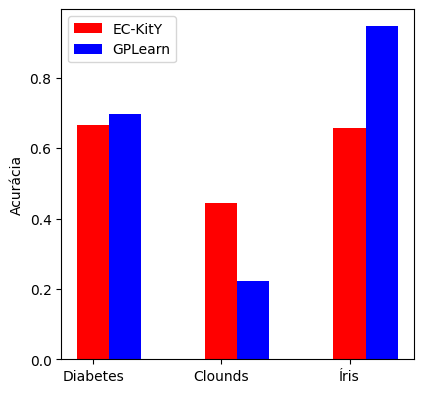

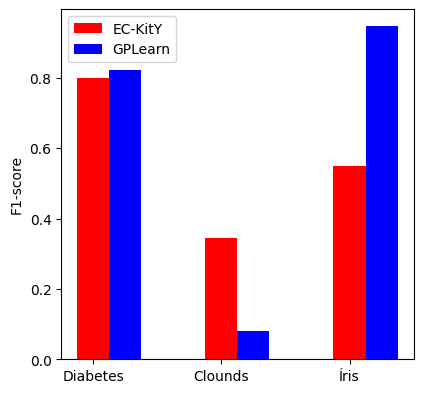

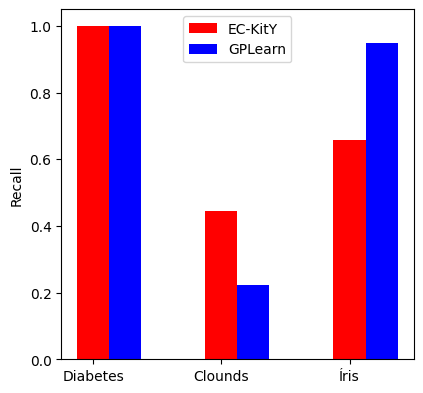

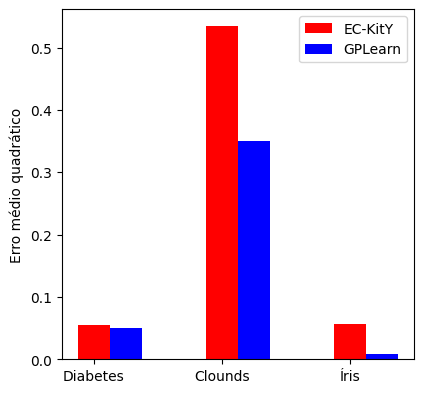

In [52]:
import numpy as np
import matplotlib.pyplot as plt


ec_kity_acuracia = [0.6666666666666666, 0.4444444444444444, 0.6578947368421053 ]
ec_kity_f1 = [0.8, 0.3440962329851218, 0.5503759398496241]
ec_kity_recall = [1.0, 0.4444444444444444, 0.6578947368421053]
ec_kity_rmse = [0.054800651297721846, 0.5346983748746058, 0.05624277370029348]

gp_acuracia = [0.6979166666666666, 0.2222222222222222, 0.9473684210526315]
gp_f1 = [0.8220858895705522, 0.0808080808080808, 0.9475748194014448]
gp_recall = [1.0, 0.2222222222222222, 0.9473684210526315]
gp_rmse = [0.049663090238560414, 0.35027448786045023, 0.008652734415429764]


# Configurações
legendas = ['Diabetes', 'Clounds', 'Íris']
barWidth = 0.25
br1 = np.arange(len(legendas))
br2 = [x + barWidth for x in br1]

# Acurácia
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.bar(br1, ec_kity_acuracia, color='red', width = barWidth, label='EC-KitY')
plt.bar(br2, gp_acuracia, color='blue', width = barWidth, label='GPLearn')
plt.ylabel('Acurácia')
plt.xticks(x, legendas)
plt.legend()

# F1-score
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 2)
plt.bar(br1, ec_kity_f1, color='red', width = barWidth, label='EC-KitY')
plt.bar(br2, gp_f1, color='blue', width = barWidth, label='GPLearn')
plt.ylabel('F1-score')
plt.xticks(x, legendas)
plt.legend()

# Recall
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.bar(br1, ec_kity_recall, color='red', width = barWidth, label='EC-KitY')
plt.bar(br2, gp_recall, color='blue', width = barWidth, label='GPLearn')
plt.ylabel('Recall')
plt.xticks(x, legendas)
plt.legend()

# RMSE
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 2)
plt.bar(br1, ec_kity_rmse, color='red', width = barWidth, label='EC-KitY')
plt.bar(br2, gp_rmse, color='blue', width = barWidth, label='GPLearn')
plt.ylabel('Erro médio quadrático')
plt.xticks(x, legendas)
plt.legend()

Pelos gráficos acima temos:

- A GPLearn possui uma acurácia bem mais elevada para os conjuntos de Diabetes e Íris, enquanto o EC-KitY foi muito mais eficiente para o conjunto de *Clounds*.
- O F1-score varia bantante entre as duas bibliotecas para os bancos de dados de Iris e *Clounds*, com ambos resultados de *Clounds* sendo insatisfatórios.
- O mesmo que foi observado no item acima pode ser visto no recall
- Embora a GPLearn tenha tido um desempenho levemente menor, o erro quadrátivo nos casos de Diabetes e Íris foram consideravelmente pequenos, e valores elevados foram encontrados apenas em *Clounds*, o que ja era previsto.

Com essas informações, podemos afirmar que, no geral, a biblioteca GPLearn gerou resultados levemente mais satisfatórios, possuindo também um tempo de execução bem mais curto do que a EC-KitY na máquina em que a maior parte dos testes foram realizados.